# Uncertainty Tutorial

In this tutorial, we show how to quickly set up and train a CNN-based regression model including uncertainty with the deep4cast package. The goal is to highlight how adding uncertainty allows the addition of bounds on predictions. The example data constitutes of a monthly 26-dimensional multivariate time series.

In [1]:
import numpy as np

import matplotlib.pyplot as plt

from deep4cast.forecasters import CNNForecaster
from deep4cast.utils import compute_mape
from pandas import read_table

%matplotlib inline

Using CNTK backend


## Data preparation

Before we can fit a model we first have to load, clean, and prepare our dataset so that the model can accept it.

In [2]:
# Load the data from file
filename = 'timeseries_data.csv'
df = read_table(filename, sep=',')

In [3]:
# Set lookback window for truncated sample time series
lookback_period = 20 # i.e. 20 months
test_length = int(len(df) * 0.1) # test on the last 10% of data
train_length = len(df) - test_length

# Prepare train and test set
ts = df.astype('float32').values
ts_train = ts[:-test_length]
ts_test = ts[-test_length-lookback_period:]

In [4]:
def criticize_model(model, metric=compute_mape):
    print('TRAIN \t Mean Absolute Percentage Error: {0:.1f}%'.format(metric(model, ts_train, ts[lookback_period:train_length])))
    print('TEST \t Mean Absolute Percentage Error: {0:.1f}%'.format(metric(model, ts_test, ts[train_length:])))

Text(0.5,1,'Black: training time series; Red: testing time series')

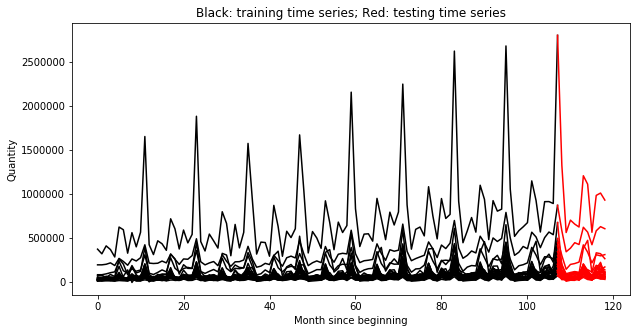

In [5]:
# Plot dataset
plt.figure(figsize=(10,5))
plt.plot(ts[:train_length], 'k')
plt.plot(range(len(ts[:train_length-1]), len(ts)), ts[train_length-1:], 'r')
plt.xlabel('Month since beginning')
plt.ylabel('Quantity')
plt.title('Black: training time series; Red: testing time series')

## Temporal Convolutional Neural Network Forecaster with Uncertainty

We choose the temporal CNN, which uses one-dimensional convolutions for modeling purposes. We specify that uncertainty should be added before the 'last' layer (ie output layer).

Note that the 'lambda' layer is included in the model summary but not the topology object.

In [6]:
# Hyper-parameters
topology = [({'layer': 'Conv1D', 'id': 'c1', 'parent': 'input'},
             {'filters': 64, 'kernel_size': 5, 'activation': 'elu'}),
            ({'layer': 'MaxPooling1D', 'id': 'mp1', 'parent': 'c1'},
             {'pool_size': 3, 'strides': 1}),
            ({'layer': 'Conv1D', 'id': 'c2', 'parent': 'mp1'},
             {'filters': 64, 'kernel_size': 3, 'activation': 'elu'}),
            ({'layer': 'MaxPooling1D', 'id': 'mp2', 'parent': 'c2'},
             {'pool_size': 4, 'strides': 2}),
            ({'layer': 'Conv1D', 'id': 'c3', 'parent': 'mp2'},
             {'filters': 128, 'kernel_size': 3, 'activation': 'elu'}),
            ({'layer': 'MaxPooling1D', 'id': 'mp3', 'parent': 'c3'},
             {'pool_size': 3, 'strides': 1}),
            ({'layer': 'Flatten', 'id': 'f1', 'parent': 'mp3'},
             {}),
            ({'layer': 'Dense', 'id': 'd1', 'parent': 'f1'},
             {'units': 128, 'activation': 'elu'}),
            ({'layer': 'Dense', 'id': 'output', 'parent': 'd1'},
             {'units': 128, 'activation': 'elu'})]

# Instantiate regression model
model = CNNForecaster(topology, batch_size=8, epochs=50, learning_rate=0.1, uncertainty='last')
model.fit(ts_train, lookback_period=lookback_period)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 20, 26)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 16, 64)            8384      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 14, 64)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 12, 64)            12352     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 5, 64)             0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 3, 128)            24704     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 1, 128)            0         
__________

Let's have a peek at what the model training and testing errors look like

In [ ]:
criticize_model(model)

Let's have a look at the history of the training loss (here mean-squared error)

In [ ]:
# Plot training error history
plt.figure(figsize=(10,5))
plt.plot(model.history.epoch, model.history.history['loss'], 'r') 
plt.xlabel('Epoch number')
plt.ylabel('Mean-squared training error')

### Prediction with uncertainty for temporal CNN by adding MC Dropout

In [ ]:
ts_pred = model.predict(ts_test)
ts_pred_mean = ts_pred['mean_prediction']   # shape = (9, 26)
ts_pred_median = ts_pred['median_prediction']
ts_pred_upper_quantile = ts_pred['upper_quantile']
ts_pred_lower_quantile = ts_pred['lower_quantile']
ts_pred_samples = ts_pred['prediction_samples']  # shape = (1000, 9, 26)

Plot of prediction samples of test set including uncertainty bounds

In [ ]:
ncols = 5
fig, axes = plt.subplots(nrows=len(ts_pred_mean.T)//ncols+1, ncols=ncols, sharex=True, sharey=True, figsize=(12, 9))

for ax, ya, yp, yp_lower, yp_upper, title in zip(axes.flat, ts[train_length:].T, ts_pred_mean.T, 
                                        ts_pred_lower_quantile.T, ts_pred_upper_quantile.T,
                                        range(1,len(ts_pred_mean.T)+1)):
    ax.plot(ya, 'k-')
    ax.plot(yp, 'g-')
    ax.plot(yp_lower, 'g:')
    ax.plot(yp_upper, 'g:')
    ax.set_title(title)

plt.tight_layout()